In [1]:
import os
# NOTE: material: https://drive.google.com/drive/u/0/folders/14J6oWZzULqtXfIv99064Cs0iHVdeat22

In [2]:
# NOTE: access to directory
dir_project = os.path.abspath(".")
print(f"{dir_project=}")
os.chdir(dir_project)
print(f"{os.getcwd()=}")

dir_project='/root/Documents/Projects/augmented_safeguard/D-NeRF'
os.getcwd()='/root/Documents/Projects/augmented_safeguard/D-NeRF'


In [3]:

import json
import math
import time

import cv2
import imageio
import lpips
import numpy as np
import torch
torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import mcubes
import trimesh
from tqdm import tqdm, trange


In [4]:
# NOTE: extended `config_parser()`

import NeRF.config_parser

def config_parser():
    import argparse
    parser = NeRF.config_parser.config_parser()

    # NOTE: D-NeRF training options
    # ------------------------------------------
    parser.add_argument("--nerf_type", type=str, default="original", help="nerf network type")
    parser.add_argument("--N_iter", type=int, default=500000, help="num training iterations")
    parser.add_argument("--do_half_precision", action="store_true", help="do half precision training and inference")

    parser.add_argument("--add_tv_loss", action="store_true", help="evaluate tv loss")
    parser.add_argument("--tv_loss_weight", type=float, default=1.e-4, help="weight of tv loss")
    # ------------------------------------------
    
    # NOTE: D-NeRF rendering options
    # ------------------------------------------
    parser.add_argument("--not_zero_canonical", action="store_true", help="if set zero time is not the canonic space")
    parser.add_argument("--use_two_models_for_fine", action="store_true", help="use two models for fine results")
    # ------------------------------------------

    return parser

In [5]:
# NOTE: parse arguments & load config
parser = config_parser()
filename_config = "configs/mutant.txt"
configs = NeRF.config_parser.load_config(parser, filename_config)
print(configs)

{'expname': 'mutant', 'basedir': './logs', 'datadir': './data/mutant', 'dataset_type': 'blender', 'nerf_type': 'direct_temporal', 'no_batching': 'True', 'not_zero_canonical': 'False', 'use_viewdirs': 'True', 'white_bkgd': 'True', 'lrate_decay': '500', 'N_iter': '800000', 'N_samples': '64', 'N_importance': '128', 'N_rand': '500', 'testskip': '1', 'precrop_iters': '500', 'precrop_iters_time': '100000', 'precrop_frac': '0.5', 'half_res': 'True', 'do_half_precision': 'False'}


In [6]:
# NOTE: assign configs to arguments

args = parser.parse_args(args=[])
args.expname = configs['expname']
args.basedir = configs['basedir']
args.datadir = configs['datadir']
args.dataset_type = configs['dataset_type']

args.nerf_type = configs['nerf_type']
args.no_batching = configs['no_batching']
args.not_zero_canonical = configs['not_zero_canonical']

args.use_viewdirs = configs['use_viewdirs']
args.white_bkgd = configs['white_bkgd']
args.lrate_decay = int(configs['lrate_decay'])

args.N_iter = int(configs['N_iter'])
args.N_samples = int(configs['N_samples'])
args.N_importance = int(configs['N_importance'])
args.N_rand = int(configs['N_rand'])
args.testskip = int(configs['testskip'])

args.precrop_iters = int(configs['precrop_iters'])
args.precrop_iters_time = int(configs['precrop_iters_time'])
args.precrop_frac = float(configs['precrop_frac'])

args.half_res = bool(configs['half_res'])
args.do_half_precision = configs['do_half_precision']

args.no_reload = True # NOTE: for now set to True as we'll implement training code

print(args)

device = torch.device("cuda")
DEBUG=False
print(device)

torch.set_default_tensor_type('torch.cuda.FloatTensor')

Namespace(N_importance=128, N_iter=800000, N_rand=500, N_samples=64, add_tv_loss=False, basedir='./logs', chunk=32768, datadir='./data/mutant', dataset_type='blender', do_half_precision='False', expname='mutant', factor=8, ft_path=None, half_res=True, i_embed=0, i_img=500, i_print=100, i_testset=50000, i_video=50000, i_weights=10000, lindisp=False, llffhold=8, lrate=0.0005, lrate_decay=500, multires=10, multires_views=4, nerf_type='direct_temporal', netchunk=65536, netdepth=8, netdepth_fine=8, netwidth=256, netwidth_fine=256, no_batching='True', no_ndc=False, no_reload=True, not_zero_canonical='False', perturb=1.0, precrop_frac=0.5, precrop_iters=500, precrop_iters_time=100000, raw_noise_std=0.0, render_factor=0, render_only=False, render_test=False, shape='greek', spherify=False, testskip=1, tv_loss_weight=0.0001, use_two_models_for_fine=False, use_viewdirs='True', white_bkgd='True')
cuda


### Visualize Dataset

In [7]:
_datadir = "./data/mutant/"

with open(os.path.join(_datadir, "transforms_test.json"), "r") as fp:
    meta = json.load(fp)

print(str(meta)[:300])

_frames = meta['frames']
_frame = _frames[0]
print(_frame)

_fname = os.path.join(_datadir, _frame['file_path'] + ".png")
print(_fname)

import imageio.v2 as imageio
img = imageio.imread(_fname) # [800, 800, 4 = RGB+mask(synthetic; from Blender)]
print(img.shape)

{'camera_angle_x': 0.6911112070083618, 'frames': [{'file_path': './test/r_000', 'rotation': 0.3141592653589793, 'time': 0.0, 'transform_matrix': [[-0.9671632051467896, 0.0898933932185173, -0.23772795498371124, -0.958311915397644], [-0.254156231880188, -0.3420792818069458, 0.904647171497345, 3.646749
{'file_path': './test/r_000', 'rotation': 0.3141592653589793, 'time': 0.0, 'transform_matrix': [[-0.9671632051467896, 0.0898933932185173, -0.23772795498371124, -0.958311915397644], [-0.254156231880188, -0.3420792818069458, 0.904647171497345, 3.6467490196228027], [-7.450581485102248e-09, 0.9353613257408142, 0.35369348526000977, 1.4257838726043701], [0.0, 0.0, 0.0, 1.0]]}
./data/mutant/./test/r_000.png
(800, 800, 4)


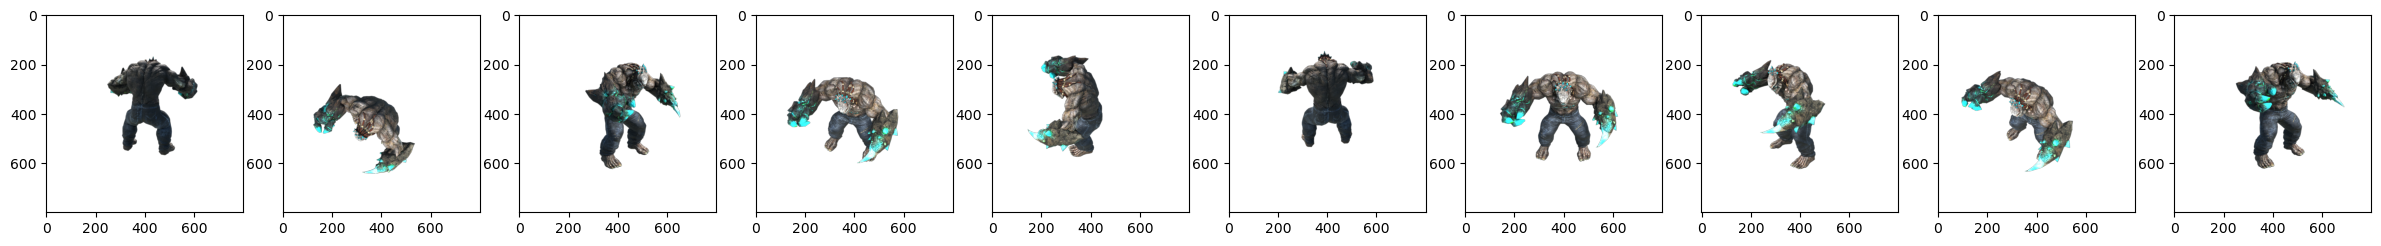

In [8]:
# NOTE: sequential visualization

fig, axis = plt.subplots(1, 10, figsize=(30, 300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)

    axis[i].imshow(img)

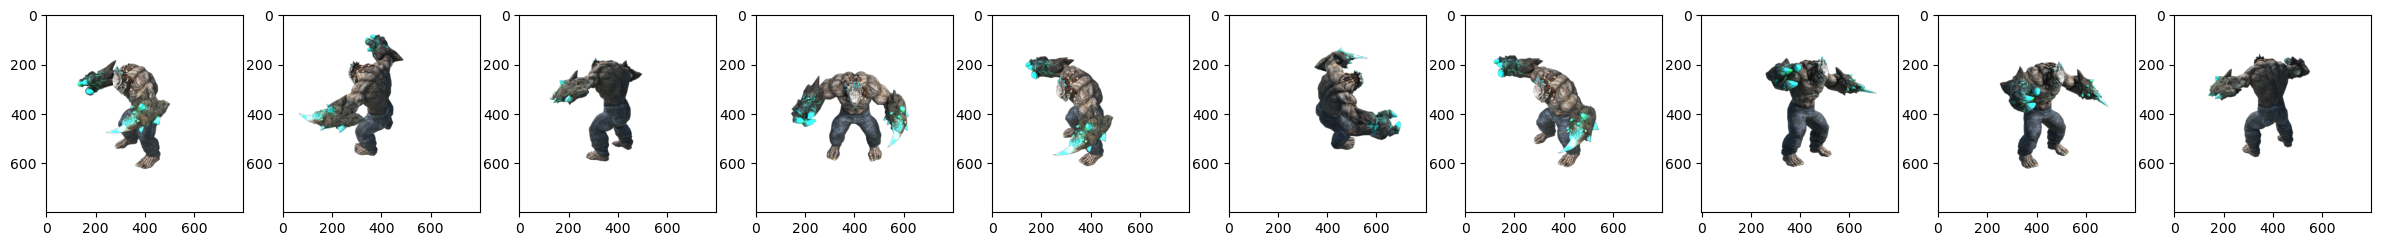

In [9]:
# NOTE: random shuffled visualization

import random
random.shuffle(_frames)
fig, axis = plt.subplots(1, 10, figsize=(30, 300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)

    axis[i].imshow(img)

In [10]:
# NOTE: decomposed channel visualization

# NOTE: blocked here to prevent manipulation of original data
if False: 
    imgs = []
    for i in range(10):
        _frame = _frames[i]
        _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

        img = imageio.imread(_fname)
        imgs.append(img)

    imgs = (np.array(imgs) / 255.0).astype(np.float32) # [0., 1.]
    print(imgs.shape)

    imgs_orig = imgs[..., :3] # RGB
    imgs_mask = imgs[..., -1] # mask

    fig, axis = plt.subplots(1, 3)
    axis[0].imshow(imgs_orig[0])
    axis[1].imshow(imgs_mask[0], cmap="gray")

    # NOTE: how plt operates with mask
    imgs = imgs[..., :3] * imgs[..., -1:] + (1-imgs[..., -1:]) # `-1:`: broadcast 
    axis[2].imshow(imgs[0])

In [11]:
# NOTE: load blender data

import NeRF.dataloader
import NeRF.pose

# NOTE: implement Blender data loader
def load_blender_data(basedir, half_res: bool=False, testskip=1):

    """
    NOTE: if D-NeRF extended, marked as # as a suffix
    """

    images, poses, render_poses, hwf, i_split = NeRF.dataloader.load_blender_data(basedir, half_res, testskip)

    splits = ["train", "val", "test"]
    metas = {}

    # NOTE: load poses
    for s in splits:
        with open(os.path.join(basedir, f"transforms_{s}.json"), "r") as fp:
            metas[s] = json.load(fp)

    all_times = [] #

    for s in splits:
        meta = metas[s]
        times = [] # 
        skip = testskip # # NOTE: `time` should be re-normalized based on this

        for t, frame in enumerate(meta['frames'][::skip]):
            times.append(
                (cur_time := frame['time'] if 'time' in frame else float(t) / (len(meta['frames'][::skip]) - 1))
            ) #

        assert times[0] == 0, "Time must start at 0" # 

        times = np.array(times).astype(np.float32) #
        all_times.append(times) #

    times = np.concatenate(all_times, 0) #

    path_transforms_render = os.path.join(basedir, "transforms_render.json")
    if os.path.exists(path_transforms_render):
        
        with open(path_transforms_render, "r") as fp:
            meta = json.load(fp)
        
        render_poses = []
        for frame in meta["frames"]:
            render_poses.append(np.array(frame["transform_matrix"]))
        render_poses = np.array(render_poses).astype(np.float32)

    else:
        render_poses = torch.stack(
            [
                NeRF.pose.pose_spherical(theta=angle, phi=-30.0, radius=4.0) 
                for angle
                in np.linspace(-180, 180, 160+1)[:-1]
            ], dim=0
        )
    render_times = torch.linspace(0.0, 1.0, render_poses.shape[0])

    return images, poses, times, render_poses, render_times, hwf, i_split


In [15]:
# NOTE: validation: load_blender_data
images, poses, times, render_poses, render_times, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)

print(f"{images.shape=}")
print(f"{i_split=}")
print(f"{poses.shape=}")
print(f"{times.shape=}")
# print(f"{times=}")

images.shape=(190, 400, 400, 4)
i_split=[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149]), array([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169]), array([

In [1]:
# NOTE: positional encoding

import NeRF.embedder

def get_embedder(multires, input_dims, i=0):
    if i == -1:
        return nn.Identity(), input_dims
    
    embed_kwargs = {
                'include_input' : True,
                'input_dims' : input_dims,
                'max_freq_log2' : multires-1,
                'num_freqs' : multires,
                'log_sampling' : True,
                'periodic_fns' : [torch.sin, torch.cos],
    }

    embedder_obj = NeRF.embedder.Embedder(**embed_kwargs)
    embed = lambda x, eo=embedder_obj : eo.embed(x)

    return embed, embedder_obj.out_dim

In [1]:
# NOTE: model
import NeRF.model

class NeRFOriginal(NeRF.model.NeRF):
    """
    
    Canonical network
    """
    def __init__(
            self, 
            D=8, 
            W=256, 
            input_ch=3, 
            input_ch_views=3, 
            output_ch=4, 
            skips=[4], 
            use_viewdirs=False, 

            input_ch_time=1,
            memory=[], 
            embed_fn=None, 
            output_color_ch=3, 
            zero_canonical=True) -> None:
        super().__init__(D, W, input_ch, input_ch_views, output_ch, skips, use_viewdirs)

        layers = [nn.Linear(input_ch, W)]
        for i in range(D-1):
            layer = nn.Linear

            in_channels = W
            if i in skips:
                in_channels+=input_ch

            layers += [layer(in_channels, W)]

        self.pts_linears = nn.ModuleList(layers)
        self.views_linears = nn.ModuleList([nn.Linear(input_ch_views+W, W//2)])

        if use_viewdirs:
            self.feature_linear = nn.Linear(W, W)
            self.alpha_linear = nn.Linear(W, 1)
            self.rgb_linear = nn.Linear(W//2, output_color_ch)
        else:
            pass
            self.output_linear = nn.Linear(W, output_ch)

    def forward(self, x, ts):

        input_pts, input_views = torch.split(
            x, 
            [self.input_ch, self.input_ch_views], dim=-1
        )
        h = input_pts

        for idx, _ in enumerate(self.pts_linears):
            h = self.pts_linears[idx](h)
            h = F.relu(h)

            if idx in self.skips:
                h = torch.cat([input_pts, h], dim=-1)

        if self.use_viewdirs:
            alpha = self.alpha_linear(h)
            feature = self.feature_linear(h)
            h = torch.cat([feature, input_views], dim=-1)

            for i, _ in enumerate(self.views_linears):
                h = self.views_linears(i)(h)
                h = F.relu(h)

            rgb = self.rgb_linear(h)
            outputs = torch.cat([rgb, alpha], dim=-1)

        else:
            outputs = self.output_linear(h)

        return outputs, torch.zeros_like(input_pts[:, :3]) # NOTE: for compatibility with Deformation network


# NOTE: here both Deformation network and Canonical network is implemented
class DirectTemporalNeRF(nn.Module):
    def __init__(self, 
                 D=8, 
                 W=256, 
                 input_ch=3,
                 input_ch_views=3, 
                 input_ch_time=1, 
                 output_ch=4, 
                 skips=[4], 
                 use_viewdirs=False, 
                 memory=[],
                 embed_fn=None, 
                 zero_canonical=True
                 ) -> None:
        super().__init__()

        # NOTE: from vanilla NeRF
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skips = skips
        self.use_viewdirs = use_viewdirs

        # NOTE: D-NeRF
        self.input_ch_time = input_ch_time
        self.memory = memory
        self.embed_fn = embed_fn
        self.zero_canonical = zero_canonical

        # NOTE: Canonical network is vanilla NeRF
        self._occ = NeRFOriginal(
            D=D, 
            W=W, 
            input_ch=input_ch,
            input_ch_views=input_ch_views,
            input_ch_time=input_ch_time,
            output_ch=output_ch,
            skips=skips,
            use_viewdirs=use_viewdirs,
            memory=memory,
            embed_fn=embed_fn,
            output_color_ch=3
        )

        # NOTE: Deformation network
        self._time, self._time_out = self.create_time_net()

        return
    
    def create_time_net(self):
        """
        ### DirectTemporalNeRF.create_time_net()

        Encoded (position, time) => delta transformation from Canonical space
        """

        layers = [
            nn.Linear(self.input_ch + self.input_ch_time, self.W)
        ]
        for i in range(self.D - 1):
            layer = nn.Linear

            in_channels = self.W
            if i in self.skips:
                in_channels += self.input_ch # NOTE: skip connection
            
            layers += [layer(in_channels, self.W)]

        return (deformation_network := nn.ModuleList(layers)), (final_deformation_layer := nn.Linear(self.W, 3))
    
    def query_time(self, new_pts, t, net, net_final):
        """
        ### DirectTemporalNeRF.query_time

        Inference Deformation network

        Encoded (position, time) => delta transformation from Canonical space

        Arguments:
        - new_pts: chunked batch samples
        - t: time, dimension is same as `new_pts`
        """

        h = torch.cat([new_pts, t], dim=-1)

        for i, l in enumerate(net):
            h = net[i](h)
            h = F.relu(h)

            if i in self.skips:
                h = torch.cat([new_pts, h], dim=-1)

        # NOTE: final layer
        return net_final(h)

    def forward(self, x, ts):

        input_pts, input_views = torch.split(
            x, 
            [self.input_ch, self.input_ch_views], 
            dim=-1
        )
        t = ts[0]
        assert len(torch.unique(t[:, :1])) == 1, "Only accepts all points from same time"

        cur_time = t[0, 0] # NOTE: any index have equivalent value
        if cur_time == 0.0 and self.zero_canonical:
            dx = torch.zeros_like(input_pts[:, :3])
        else:
            dx = self.query_time(
                input_pts, 
                t, 
                self._time, 
                self._time_out
            ) # NOTE: deformation network
            input_pts_orig = input_pts[:, :3] # NOTE: drop direction; but was it already dropped by torch.split?

            # NOTE: re-embed with delta transformations
            input_pts = self.embed_fn(input_pts_orig + dx) 

        # NOTE: infer canonical network
        out, _ = self._occ(
            torch.cat([input_pts, input_views], dim=-1), 
            t # NOTE: `t` is unused
        )

        return out, dx
    
class NeRF:
    @staticmethod
    def get_by_name(type, *args, **kwargs):
        print(f"NeRF type selected: {type}")

        if type == "original":
            model = NeRFOriginal(*args, **kwargs)
        elif type == "direct_temporal":
            model = DirectTemporalNeRF(*args, **kwargs)
        else:
            raise ValueError(f"Type {type} not recognized.")
        
        return model


NameError: name 'nn' is not defined

In [ ]:
# NOTE: evaluate networks

import NeRF.model

def batchify(fn, chunk):

    if chunk is None:
        return fn
    
    def ret(inputs_pos, inputs_time):
        num_batches = inputs_pos.shape[0]

        out_list = []
        dx_list = []
        for i in range(0, num_batches, chunk):
            out, dx = fn(inputs_pos[i:i+chunk], [inputs_time[0][i:i+chunk], inputs_time[1][i:i+chunk]])
            out_list += [out]
            dx_list += [dx]

        return torch.cat(out_list, dim=0), torch.cat(dx_list, dim=0)
    
    return ret

def run_network(
    inputs, 
    viewdirs, 
    frame_time, 
    fn, 
    embed_fn, 
    embeddirs_fn, 
    embedtime_fn, 
    netchunk=1024*64, 
    embd_time_discr=True
):
    
    assert len(torch.unique(frame_time)) == 1, "Only accepts all points from same time"


    if embd_time_discr:
        B, N, _ = inputs.shape
        input_frame_time = frame_time[:, None].expand([B, N, 1])
        input_frame_time_flat = torch.reshape(input_frame_time, [-1, 1])
        embedded_time = embedtime_fn(input_frame_time_flat)
        embedded_times = [embedded_time, embedded_time]
    else:
        assert NotImplementedError

    embedded = NeRF.model.embed(inputs, viewdirs, fn, embed_fn, embeddirs_fn)

    outputs_flat, position_delta_flat = batchify(fn, netchunk)(embedded, embedded_times)
    outputs = torch.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]])
    position_delta = torch.reshape(position_delta_flat, list(inputs.shape[:-1]) + [position_delta_flat.shape[-1]])

    return outputs, position_delta


def create_nerf(args):

    # NOTE: `input_ch`: dimension of embedded positions
    embed_fn, input_ch = get_embedder(args.multires, 3, args.i_embed)

    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        # NOTE: `input_ch_views`: dimension of embedded directions
        embeddirs_fn, input_ch_views = get_embedder(args.multires_view, 3, args.i_embed)

    embedtime_fn, input_ch_time = get_embedder(args.multires, 1, args.i_embed)

    output_ch = 5 if args.N_importance > 0 else 4
    skips = [4]
    model = NeRF.get_by_name(
        args.nerf_type, 
        D=args.netdepth, 
        W=args.netwidth, 
        input_ch=input_ch, 
        output_ch=output_ch, 
        skips=skips,
        input_ch_views=input_ch_views,
        input_ch_time=input_ch_time, 
        use_viewdirs=args.use_viewdirs,
        embed_fn=embed_fn, 
        zero_canonical=not args.not_zero_canonical
    ).to(device)
    grad_vars = list(model.parameters())

    model_fine = None
    if args.use_two_models_for_fine:
        model_fine = NeRF.get_by_name(
            args.nerf_type, 
            D=args.netdepth_fine, 
            W=args.netwidth_fine,
            input_ch=input_ch, 
            output_ch=output_ch, 
            skips=skips,
            input_ch_views=input_ch_views,
            input_ch_time=input_ch_time,
            use_viewdirs=args.use_viewdirs,
            embed_fn=embed_fn, 
            zero_canonical=not args.not_zero_canonical,
        ).to(device)
        grad_vars += list(model_fine.parameters())

    # NOTE: helper function to running network
    network_query_fn = lambda inputs, viewdirs, ts, network_fn: run_network(
        inputs, 
        viewdirs, 
        ts, 
        network_fn, 
        embed_fn=embed_fn, 
        embeddirs_fn=embeddirs_fn, 
        embedtime_fn=embedtime_fn, 
        netchunk=args.netchunk, 
        embd_time_discr=args.nerf_type != "temporal"
    )

    # NOTE: create optimizer
    optimizer = torch.optim.Adam(params=grad_vars, lr=args.lrate, betas=(0.9, 0.999))
    '''
    if args.do_half_precision:
        print("Run model at half precision")
        if model_fine is not None:
            [model, model_fine], optimizers = amp.initialize([model, model_fine], optimizer, opt_level='O1')
        else:
            model, optimizers = amp.initialize(model, optimizer, opt_level='O1')
    '''

    start = 0
    basedir = args.basedir
    expname = args.expname

    
    ##########################
    # NOTE: Load checkpoints
    if args.ft_path is not None and args.ft_path!='None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload:
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step']
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict'])
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict'])
        print(f'Loaded from {ckpt_path}')
    ##########################

    render_kwargs_train = {
        'network_query_fn' : network_query_fn,
        'perturb' : args.perturb,
        'N_importance' : args.N_importance,
        'network_fine': model_fine,
        'N_samples' : args.N_samples,
        'network_fn' : model,
        'use_viewdirs' : args.use_viewdirs,
        'white_bkgd' : args.white_bkgd,
        'raw_noise_std' : args.raw_noise_std,
        'use_two_models_for_fine' : args.use_two_models_for_fine,
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp

    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.0

    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer



In [ ]:
# NOTE: rendering
from typing import Dict
import NeRF.rendering
import NeRF.sampler

def render_rays(
    ray_batch, 
    network_fn, 
    network_query_fn, 
    N_samples, 
    retraw=False, 
    lindisp=False, 
    perturb=0.0, 
    N_importance=0, 
    network_fine=None, 
    white_bkgd=False, 
    raw_noise_std=0.0, 
    verbose=False, 
    pytest=False, 
    z_vals=None, 
    use_two_models_for_fine=False
):
    def __stability_check(ret: Dict):
        if False: # TODO: add DEBUG
            return
        for key, tensor in ret.items():
            if torch.isnan(tensor).any():
                print(f"[ERROR] Numerical error! {key=} contains NaN.")
            if torch.isinf(tensor).any():
                print(f"[ERROR] Numerical error! {key=} contains INF.")

    rays_o, rays_d, viewdirs, near, far, frame_time = NeRF.rendering.decompose_ray_batch(ray_batch, is_time_included=False)
    N_rays = ray_batch.shape[0]
    z_samples = None
    rgb_map_0, disp_map_0, acc_map_0, position_delta_0 = None, None, None, None

    if z_vals is None:
        z_vals = NeRF.rendering.sample_z(near, far, N_samples, lindisp)
        z_vals = z_vals.expand([N_rays, N_samples])
        z_vals = NeRF.rendering.add_noise_z(z_vals, perturb, pytest)

        pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

        if N_importance <= 0: # NOTE: coarse network only
            raw, position_delta = network_query_fn(pts, viewdirs, frame_time, network_fn)
            rgb_map, disp_map, acc_map, weights, depth_map = NeRF.rendering.raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest)
        else: # NOTE: coarse + fine network
            if use_two_models_for_fine:
                raw, position_delta_0 = network_query_fn(pts, viewdirs, frame_time, network_fn)
                rgb_map_0, disp_map_0, acc_map_0, weights, _ = NeRF.rendering.raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest)
            else:
                with torch.no_grad():
                    raw, _ = network_query_fn(pts, viewdirs, frame_time, network_fn)
                    _, _, _, weights, _ = NeRF.rendering.raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest)

            # NOTE: importance sampling
            z_vals_mid = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
            z_importance_samples = NeRF.sampler.sample_pdf(
                z_vals_mid, 
                weights[..., 1:-1], 
                N_importance, 
                det=(perturb == 0.0), 
                pytest=pytest
            )
            z_importance_samples = z_importance_samples.detach()

            # NOTE: aggregate importance samples
            z_vals, __IDX_NO_NEED = torch.sort(
                torch.cat([z_vals, z_importance_samples], dim=-1),
                dim=-1
            )

    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
    run_fn = network_fn if network_fine is None else network_fine
    raw, position_delta = network_query_fn(pts, viewdirs, frame_time, run_fn)
    rgb_map, disp_map, acc_map, weights, _ = NeRF.rendering.raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest)

    ret = {'rgb_map' : rgb_map, 'disp_map' : disp_map, 'acc_map' : acc_map, 'z_vals' : z_vals,
           'position_delta' : position_delta}
    if retraw:
        ret['raw'] = raw
    if N_importance > 0:
        if rgb_map_0 is not None:
            ret['rgb0'] = rgb_map_0
        if disp_map_0 is not None:
            ret['disp0'] = disp_map_0
        if acc_map_0 is not None:
            ret['acc0'] = acc_map_0
        if position_delta_0 is not None:
            ret['position_delta_0'] = position_delta_0
        if z_samples is not None:
            ret['z_std'] = torch.std(z_samples, dim=-1, unbiased=False)  # [N_rays]

    __stability_check(ret)
    
    return ret